# xNES tests

Tests for PINTS' xNES implementation.

We start by visually inspecting its behaviour on selected problems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from plotnine import *

import pints
import pints.toy
import pints.cptests.xnes as cp

from utils import (
    function,
    function_between_points,
    technicolor_dreamline,
    run_replicates,
)

method = pints.XNES
parallel = True

## Logistic model - no transformations


In [2]:
model = pints.toy.LogisticModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
values += np.random.normal(0, 5, values.shape)
problem = pints.SingleOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [0, 0.5]
ylim = [10, 100]
boundaries = pints.RectangularBoundaries(
    [xlim[0], ylim[0]], [xlim[1], ylim[1]])

x0 = boundaries.sample(1)[0]

In [3]:
controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(False)  # This is faster

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     3      5938.782  5938.782   0:00.0
1     9      5938.782  20235.4    0:00.0
2     15     5938.782  8306.817   0:00.0
3     21     5837.815  5837.815   0:00.0
20    123    1880.289  1880.289   0:00.0
40    243    1879.674  1879.684   0:00.0
60    363    1879.671  1879.671   0:00.0
80    483    1879.671  1879.671   0:00.0
100   603    1879.671  1879.671   0:00.0
120   723    1879.671  1879.671   0:00.1
140   843    1879.671  1879.671   0:00.1
160   963    1879.671  1879.671   0:00.1
180   1083   1879.671  1879.671   0:00.1
200   1203   1879.671  1879.671   0:00.1
220   1323   1879.671  1879.671   0:00.1
240   1443   1879.671  1879.671   0:00.1
260   1563   1879.671  1879.671   0:00.1
280   1683   1879.671  1879.671   0:00.1
298   1785   1879.671  1879.671   0:00.1
Halting: No significant change for 200 iterations.
0.13 

  Found       xbest        Relative error
   1.029e-01   1.000e-01   2.889% 
   4.889e+01   5.000e+01  -2.216% 



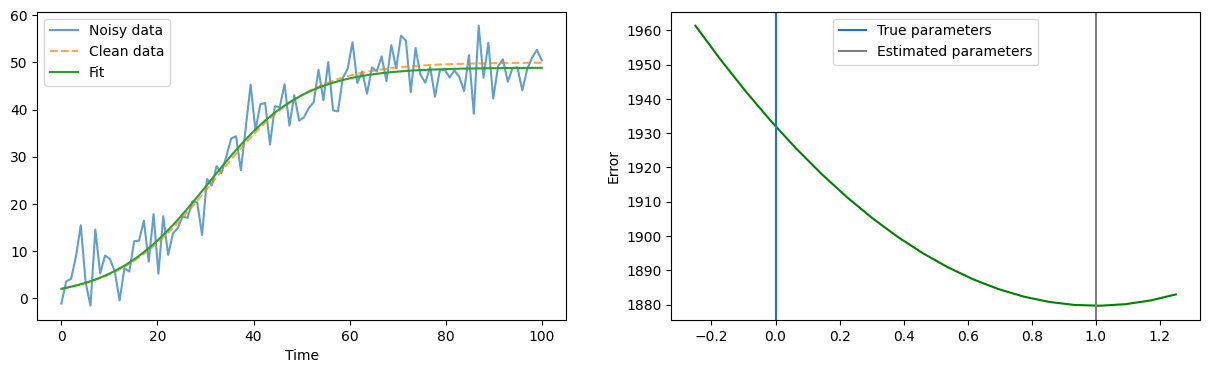

In [4]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

Works well!

### Detailed run

In [5]:
x0 = [0.4, 90]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(80):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

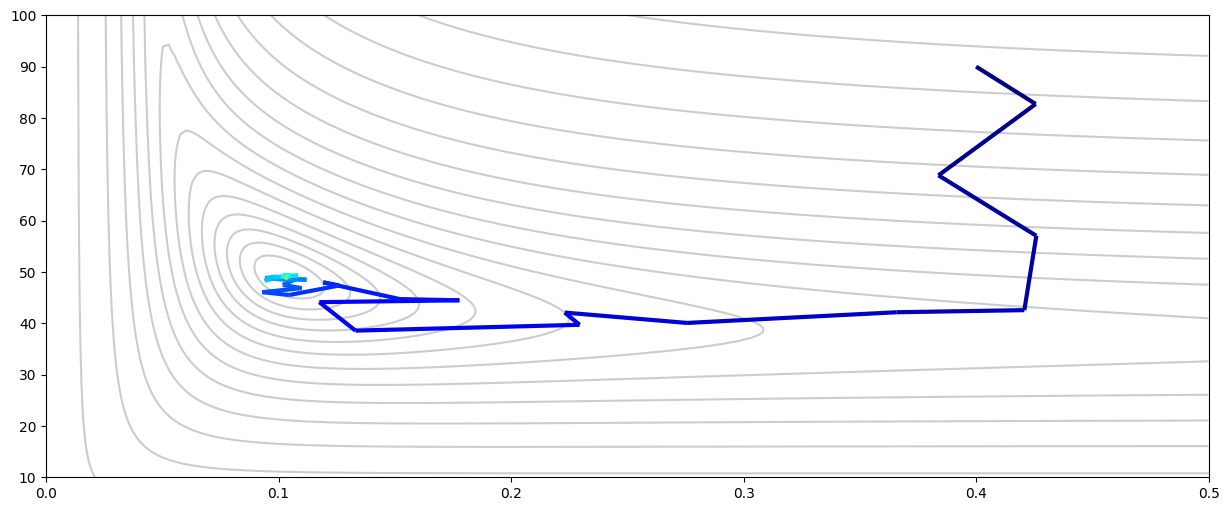

In [6]:
# Create points for contour plot of marginal density
levels = np.geomspace(1e3, 4e5, 20)
x = np.linspace(*xlim, 200)
y = np.linspace(*ylim, 150)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Interestingly, xNES starts off quite differently than CMAES does, but quickly converges to the same solution.

## Neal's funnel

In [7]:
log_pdf = pints.toy.NealsFunnelLogPDF()
x0 = 9 * np.ones(10, dtype=float)
x0[-1] = 7

opt = method(x0)
walk = [x0]
for i in range(200):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

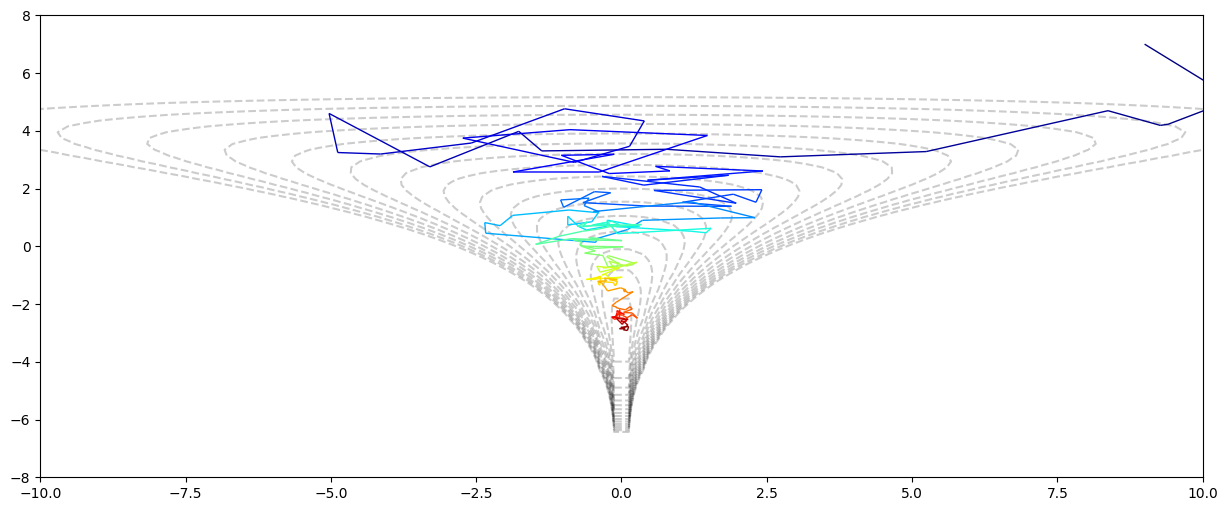

In [8]:
# Create points for contour plot of marginal density
xlim = -10, 10
ylim = -8, 8
levels = np.linspace(-7, -1, 20)
x = np.linspace(*xlim, 80)
y = np.linspace(*ylim, 80)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Here PINTS' xNES struggles more than CMAES.
We can repeat with more iterations to see what it does next.

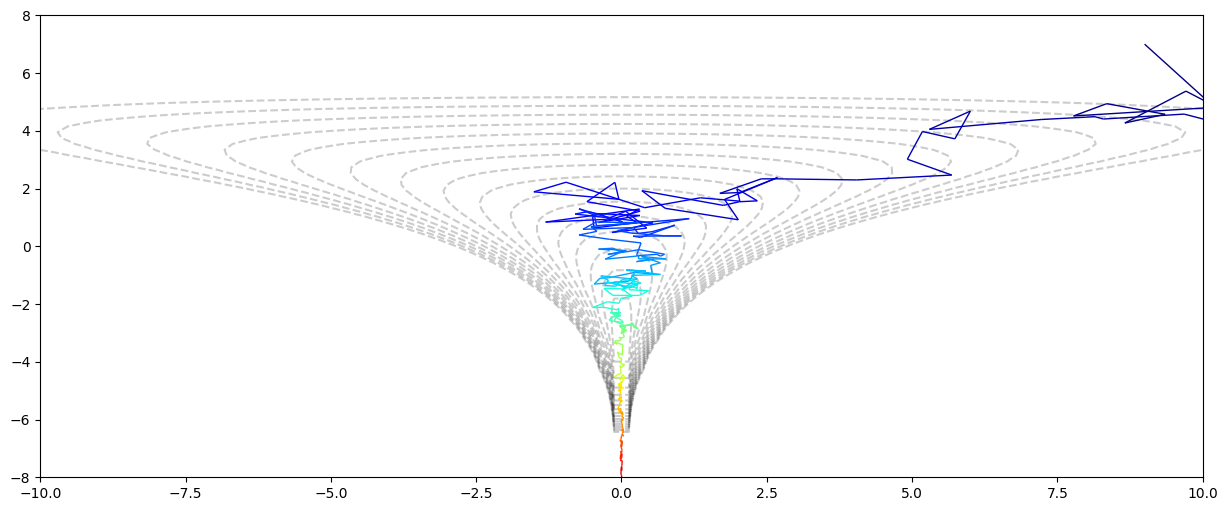

In [10]:
opt = method(x0)
walk = [x0]
for i in range(400):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

So it looks to be OK, just slower.

## Rosenbrock function

In [11]:
error = pints.toy.RosenbrockError()
x0 = [-4, -2]

opt = method(x0, sigma0=1)
walk = [x0]
for i in range(5000):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

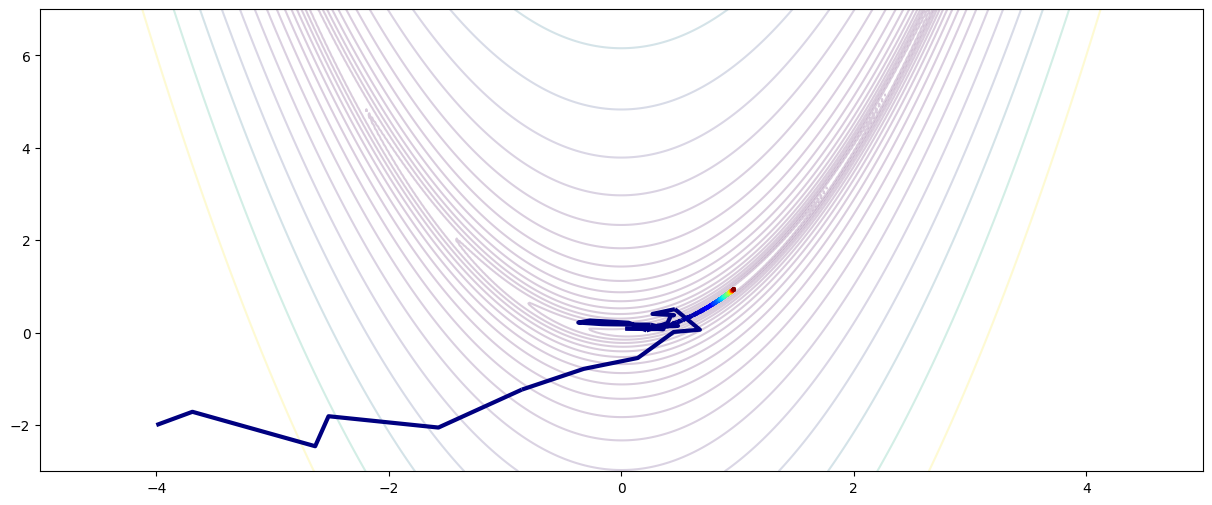

In [12]:
# Create points for contour plot of marginal density
xlim = [-5, 5]
ylim = [-3, 7]
levels = np.geomspace(1, 1e4, 20) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Zoom view:

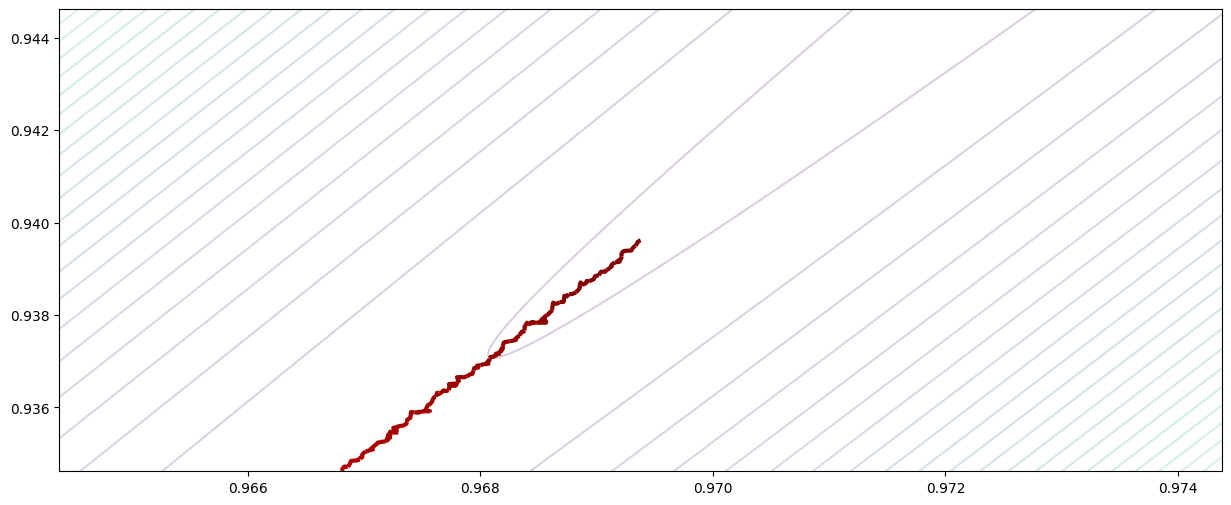

In [13]:
# Create points for contour plot of marginal density
xbest = walk[-1, :]
xlim = [xbest[0] - 0.005, xbest[0] + 0.005]
ylim = [xbest[1] - 0.005, xbest[1] + 0.005]
levels = np.geomspace(1, 1.03, 30) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

We can see that, unlike CMA-ES, xNES seems to struggle a bit here (Note the much larger number of iterations).

We can let it run for a bit to see that this doesn't go away:

In [173]:
x0 = [0, 0]
controller = pints.OptimisationController(error, x0, sigma0=1, method=pints.XNES)
controller.set_max_iterations(1000)
controller.set_log_to_screen(False)
xbest, fbest = controller.run()
print(fbest)

0.043682700179811615


In [282]:
import pygmo as pg

class rb:
    def fitness(self, x):
        return [error(x)]
    def get_bounds(self):
        return ([-5, -5], [-3, 3])

prob = pg.problem(rb())
pop = pg.population(prob, size=6)
algo = pg.algorithm(pg.xnes(gen=1000))
pop = algo.evolve(pop)
best_fitness = pop.get_f()[pop.best_idx()]

print(best_fitness) 


[8.02901648e-09]


In [328]:
import scipy
import scipy.linalg
import warnings

class XNES(pints.PopulationBasedOptimiser):
    """
    Finds the best parameters using the xNES method described in [1]_, [2]_.

    xNES stands for Exponential Natural Evolution Strategy, and is
    designed for non-linear derivative-free optimization problems [1]_.

    Extends :class:`PopulationBasedOptimiser`.

    References
    ----------
    .. [1] Glasmachers, Schaul, Schmidhuber et al. (2010) "Exponential natural
           evolution strategies". Proceedings of the 12th annual conference on
           Genetic and evolutionary computation.
           https://doi.org/10.1145/1830483.1830557

    .. [2] PyBrain: The Python machine learning library
           http://pybrain.org
    """
    def __init__(self, x0, sigma0=None, boundaries=None):
        super(XNES, self).__init__(x0, sigma0, boundaries)

        # Set initial state
        self._running = False
        self._ready_for_tell = False

        # Samples
        self._zs = None       # Normalised samples
        self._xs = None       # De-normalised samples (mu + A dot zs)
        self._bounded_xs = None   # Subset of xs that are within the boundaries
        self._bounded_ids = None  # Indices of those xs

        # Normalisation / distribution
        self._mu = pints.vector(x0)     # Mean
        self._A = None                  # Covariance

        # Best solution seen
        self._x_best = pints.vector(x0)
        self._f_best = np.inf

        # Best guess of the solution is mu
        # We don't have f(mu), so we approximate it by min f(sample)
        self._f_guessed = np.inf

        self.prrrr = False

    def ask(self):
        """ See :meth:`Optimiser.ask()`. """
        # Initialise on first call
        if not self._running:
            self._initialise()

        # Ready for tell now
        self._ready_for_tell = True

        # Create new samples (normalised, and user values)
        self._zs = np.array([np.random.normal(0, 1, self._n_parameters)
                             for i in range(self._population_size)])
        self._xs = np.array([self._mu + np.dot(self._A, self._zs[i])
                             for i in range(self._population_size)])

        # Boundaries? Then only pass user xs that are within bounds
        if self._boundaries is not None:
            self._bounded_ids = np.nonzero(
                [self._boundaries.check(x) for x in self._xs])
            self._bounded_xs = self._xs[self._bounded_ids]
            if len(self._bounded_xs) == 0:     # pragma: no cover
                warnings.warn(
                    'All points requested by XNES are outside the boundaries.')
        else:
            self._bounded_xs = self._xs

        # Set as read-only and return
        self._bounded_xs.setflags(write=False)
        return self._bounded_xs

    def f_best(self):
        """ See :meth:`Optimiser.f_best()`. """
        return self._f_best

    def f_guessed(self):
        """ See :meth:`Optimiser.f_guessed()`. """
        return self._f_guessed

    def _initialise(self):
        """
        Initialises the optimiser for the first iteration.
        """
        assert not self._running

        # Shorthands
        d = self._n_parameters
        n = self._population_size

        # Learning rates, see Table 1
        # TODO Allow changing before run() with method call
        self._eta_mu = 1
        # TODO Allow changing before run() with method call
        self._eta_A = 0.6 * (3 + np.log(d)) * d ** -1.5

        # Pre-calculated utilities, see Table 1
        self._us = np.maximum(0, np.log(n / 2 + 1) - np.log(1 + np.arange(n)))
        self._us /= np.sum(self._us)
        self._us -= 1 / n

        # Center of distribution
        self._mu = np.array(self._x0, copy=True)

        # Initial square root of covariance matrix
        self._A = np.eye(d) * self._sigma0

        # Identity matrix of appropriate size
        self._I = np.eye(d)

        # Update optimiser state
        self._running = True

    def name(self):
        """ See :meth:`Optimiser.name()`. """
        return 'Exponential Natural Evolution Strategy (xNES)'

    def running(self):
        """ See :meth:`Optimiser.running()`. """
        return self._running

    def _suggested_population_size(self):
        """ See :meth:`Optimiser._suggested_population_size(). """
        return 4 + int(3 * np.log(self._n_parameters))

    def tell(self, fx):
        """ See :meth:`Optimiser.tell()`. """
        if not self._ready_for_tell:
            raise Exception('ask() not called before tell()')
        self._ready_for_tell = False

        # Boundaries? Then reconstruct full fx vector
        if self._boundaries is not None and len(fx) < self._population_size:
            bounded_fx = fx
            fx = np.ones((self._population_size, )) * np.inf
            fx[self._bounded_ids] = bounded_fx

        # Order the normalized samples according to the scores
        order = np.argsort(fx)
        self._zs = self._zs[order]

        # Update center
        Gd = np.dot(self._us, self._zs)

        if self.prrrr:
            Gd_check = 0
            for u, z in zip(self._us, self._zs):
                Gd_check += u * z
            print(Gd, Gd_check)
        
        self._mu += self._eta_mu * np.dot(self._A, Gd)
        #self._mu += self._eta_mu * Gd
        #if self.prrrr:
        #    print(Gd, np.dot(self._A, Gd))

        # Update root of covariance matrix
        # Note that this is equation 11 (for the eta-sigma=eta-B case), not the
        # more general equations 9&10 version given in Algorithm 1
        Gm = np.dot(
            np.array([np.outer(z, z).T - self._I for z in self._zs]).T,
            self._us)
        Gm = 0.5 * np.sum([u * (np.outer(z, z.T) - self._I) for u, z in zip(self._us, self._zs)], axis=0)
                
        if self.prrrr:
            Gm_check = 0
            for u, z in zip(self._us, self._zs):
                Gm_check += u * (np.outer(z, z.T) - self._I)
            Gm_check /= 2
            print()
            print(Gm)
            print(Gm_check)        

        self._A *= scipy.linalg.expm(0.5 * self._eta_A * Gm)

        

        # Update f_guessed on the assumption that the lowest value in our
        # sample approximates f(mu)
        self._f_guessed = fx[order[0]]
        if self.prrrr:
            print(fx[order[0]], fx)

        # Update x_best and f_best
        if self._f_guessed < self._f_best:
            self._x_best = np.array(self._xs[order[0]], copy=True)
            self._f_best = fx[order[0]]

    def x_best(self):
        """ See :meth:`Optimiser.x_best()`. """
        return self._x_best

    def x_guessed(self):
        """ See :meth:`Optimiser.x_guessed()`. """
        return np.array(self._mu, copy=True)


opt = XNES(x0, sigma0=0.1)
opt.prrrr = True
walk = [x0]
for i in range(1):
    opt.tell([error(x) for x in opt.ask()])


[0.24648254 0.25428864] [0.24648254 0.25428864]

[[-0.63533925 -0.49787837]
 [-0.49787837 -0.8327268 ]]
[[-0.63533925 -0.49787837]
 [-0.49787837 -0.8327268 ]]
1.0735671553547212 [1.4652023314169877, 1.6907052417765733, 2.8282901713958584, 5.722019738105633, 7.130674056816281, 1.0735671553547212]


In [322]:
x0 = [0, 0]
controller = pints.OptimisationController(error, x0, sigma0=1, method=XNES)
controller.set_max_iterations(1000)
controller.set_log_to_screen(False)
xbest, fbest = controller.run()
print(fbest)


0.026131377674256627


## Fitzhugh-Nagumo model - fully observable

In [ ]:
model = pints.toy.FitzhughNagumoModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
r = np.random.default_rng(1)  # Create a seeded generator to get reproducible noise
values += r.normal(0, 0.5, values.shape)
problem = pints.MultiOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [1e-3, 2]
ylim = [1e-3, 2]
zlim = [1e-3, 10]
boundaries = np.vstack((xlim, ylim, zlim)).T
boundaries = pints.RectangularBoundaries(boundaries[0], boundaries[1])

In [ ]:
# Use a fixed starting point for this one
x0 = xtrue * 1.3

controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(parallel)

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

In [ ]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

As with CMAES, we see rapid convergence from the chosen starting point.

### Detailed run

In [ ]:
# Create points for contour plot of marginal density
def contour(xlim, ylim, idx):
    n = 80
    x = np.linspace(*xlim, n)
    y = np.linspace(*ylim, n)
    X, Y = np.meshgrid(x, y)
    Z = [[error(idx(i, j)) for i in x] for j in y]
    return X, Y, Z

n = 100
X1, Y1, Z1 = contour(xlim, ylim, idx=lambda i, j: [i, j, xtrue[2]])
levels1 = np.geomspace(95, 1250, n)
X2, Y2, Z2 = contour(xlim, zlim, idx=lambda i, j: [i, xtrue[1], j])
levels2 = np.geomspace(95, 1000, n)
X3, Y3, Z3 = contour(ylim, zlim, idx=lambda i, j: [xtrue[0], i, j])
levels3 = np.geomspace(95, 1e3, n)

In [ ]:
np.random.seed(1)
x0 = [0.75, 1.5, 3]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(400):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)
np.random.seed()

In [ ]:
# Plot contours and optimiser progress
def fig3():
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.contourf(X1, Y1, Z1, levels=levels1, cmap='viridis_r', alpha=0.7)
    ax1.set_xlim(*xlim); ax1.set_ylim(*ylim)
    ax1.set_xlabel('p1'); ax1.set_ylabel('p2')
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.contourf(X2, Y2, Z2, levels=levels2, cmap='viridis_r', alpha=0.7)
    ax2.set_xlim(*xlim); ax2.set_ylim(*zlim)
    ax2.set_xlabel('p1'); ax2.set_ylabel('p3')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.contourf(X3, Y3, Z3, levels=levels3, cmap='viridis_r', alpha=0.7)
    ax3.set_xlim(*ylim); ax3.set_ylim(*zlim)
    ax3.set_xlabel('p2'); ax3.set_ylabel('p3')
    return fig, ax1, ax2, ax3

def p3(ax1, ax2, ax3, x, marker='x', markersize=10, color=None):
    ax1.plot(x[0], x[1], marker, markersize=markersize, color=color)
    ax2.plot(x[0], x[2], marker, markersize=markersize, color=color)
    ax3.plot(x[1], x[2], marker, markersize=markersize, color=color)

fig, ax1, ax2, ax3 = fig3()
technicolor_dreamline(ax1, walk[:, 0], walk[:, 1], lw=3)
technicolor_dreamline(ax2, walk[:, 0], walk[:, 2], lw=3)
technicolor_dreamline(ax3, walk[:, 1], walk[:, 2], lw=3)
p3(ax1, ax2, ax3, xtrue)

plt.show()

# Testing performance

## 2D Parabola

If this doesn't work, something is broken.

In [ ]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 20), 20, cp.two_dim_parabola, parallel)
print(t.format())

In [ ]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.25, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Both lines move in the right direction, and the error quickly goes to zero.

## Rosenbrock function

In [31]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 2000, 30), 10, cp.rosenbrock, parallel)
print(t.format())

3.75 seconds


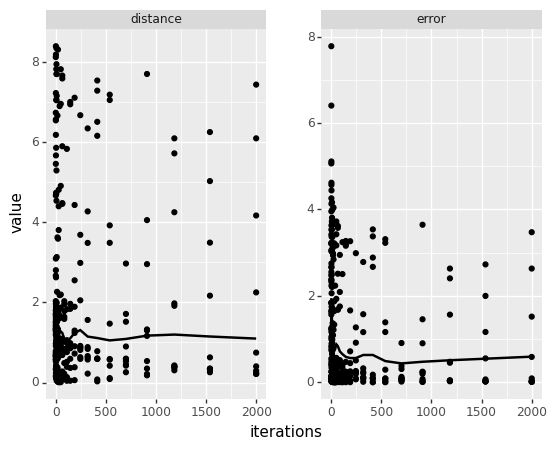

<ggplot: (8728837557089)>

In [32]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

## Bounded, untransformed logistic model

In [ ]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 300, 30), 10, cp.bounded_untransformed_logistic, parallel)
print(t.format())

In [ ]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Looks good!

## Bounded Fitzhugh-Nagumo

In [ ]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 10), 10, cp.bounded_fitzhugh_nagumo, parallel)
print(t.format())

In [ ]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

This is an interesting test!

- Convergence is all-or-nothing: Either it gets to almost the right answer in 10-20 iterations, or it gets stuck somewhere (if you don't see any failing examples, try re-running).
- Many runs show an increased distance from ~30 to ~50 iterations: this is presumably the optimiser overfitting to the noise.